In [3]:
from sklearn.cluster import KMeans
import numpy as np
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy
from PIL import Image
from scipy.spatial import ConvexHull
import sys
from skimage.measure import label

In [4]:
def getConnectedPoints(i):
    l = []
    for o in range(cleftsA.shape[0]):
        for p in range(cleftsA.shape[1]):
            for q in range(cleftsA.shape[2]):
                if lb[0][o,p,q] == i:
                    l.append([o,p,q])
    return l

In [15]:
def getVolume(points):
    n = np.array(points)
    n = n.T
    xMAX = max(n[1,:])
    xMIN = min(n[1,:])
    yMAX = max(n[2,:])
    yMIN = min(n[2,:])
    zMAX = max(n[0,:])
    zMIN = min(n[0,:])
    return (xMAX,xMIN,yMAX,yMIN,zMAX,zMIN)

In [31]:
def get3DPoints(points):
    l3D = []
    zMIN = int(getVolume(points)[5])
    for i in points:
        for j in range(10):
            l3D.append([i[1],i[2],(i[0]-zMIN)*10+j])
    return l3D

In [7]:
def EdgesOfHull(pts):
    edges = []
    hull = ConvexHull(pts)

    for s in hull.simplices:
        if ((s[0],s[1]) not in edges) and ((s[1],s[0]) not in edges):
            edges.append((s[0],s[1]))
        if ((s[1],s[2]) not in edges) and ((s[2],s[1]) not in edges):
            edges.append((s[1],s[2]))
        if ((s[0],s[2]) not in edges) and ((s[2],s[0]) not in edges):
            edges.append((s[0],s[2]))
    return edges

In [8]:
### this function is writen by nathanieltroutman. URL = nathanieltroutman.net/?q=content/calculating-minimum-volume-bounding-box
### many thanks to this implementation!
def findOBBEdge(edges, points):
    # shift the points such that the minimum x, y, z values
    # in the entire set of points is 0.
    shift = points.min(axis=0)
    points = points - shift
    
    min_volume = sys.maxsize
    
    # try every pair of edges (ordering is not important)
    for idx, edge1_idx in enumerate(edges):        
        e1 = points[edge1_idx[0]] - points[edge1_idx[1]]
        for idx2, edge2_index in enumerate(edges[(idx+1):]):            
            e2 = points[edge2_index[0]] - points[edge2_index[1]]
            
            # transform the two edges into a orthogonal basis
            w = vec_cross(e1, e2) # returns normalized vector
            u = vec_cross(w, e1)
            v = vec_cross(u, w)
            
            # project all the points on to the basis u1, u2 u3
            p = calcProjections(points, u, v, w)

            volume, mins, maxes = calcVolume(p)
            
            # we are looking for the minimum volume box
            if volume <= min_volume:
                min_volume = volume
                specs = u, v, w, mins, maxes, volume
                
    u, v, w, mins, maxes, volume = specs
        
    # get the corner by using our projections, then shift it to move
    # it back into the same origin as the original set of points
    corner = u * mins[0] + v * mins[1] + w * mins[2]
    corner += shift
    
    # create the sides which are vectors with the magnitude the length
    # of that side
    v1 = u * (maxes[0] - mins[0])
    v2 = v * (maxes[1] - mins[1])
    v3 = w * (maxes[2] - mins[2])
    
    return corner, v1, v2, v3
    
def calcVolume(p):
    """Calculates the volume of the box that would encompass the given
    points using the given projection. projection is sized (NxM) where
    N is the number of points and M is the number of vectors they were
    projected onto. Also return the minimum and maximum bounds along
    each of those vectors."""
        
    # the minimum and maximum projection of each basis vector
    mins = p.min(axis=0)
    maxes = p.max(axis=0)
    
    # the volume product of each difference between the maximum and
    # minimum values from the projection onto each basis vector
    volume = np.prod(maxes - mins)
        
    return volume, mins, maxes  

def calcProjections(points, *vectors):
    """Calculates the projection of points (NxD) onto the vectors 
    (MxD) and return the projections p which is a matrix sized (N, M) 
    where N is the number of points and M is the number of vectors.
    p[i][j], is the projection of points[i] onto vectors[j] (which is
    between 0 and 1)."""
    
    u = np.array(vectors)
    
    # project the points onto the vectors into on fell swoop
    d = np.dot(points, u.T)
    
    # this is the dot product of each vector with itself
    v2 = np.diag(np.inner(u, u))
    
    p = d / v2
    
    return p
    
def vec_cross(u, v):
    """Return the normalized cross product of u and v."""
    w = np.cross(u, v)
    w = w/float(np.sqrt(np.sum(v**2)))
    return w


In [9]:
def getMBBVolume(mbb):
    u = (mbb[1][0]**2 + mbb[1][1]**2+mbb[1][2]**2)**0.5
    v = (mbb[2][0]**2 + mbb[2][1]**2+mbb[2][2]**2)**0.5
    w = (mbb[3][0]**2 + mbb[3][1]**2+mbb[3][2]**2)**0.5
    x = min(u,v,w)
    z = max(u,v,w)
    if (u!=x) and (u!=z):
        y=u
    elif (v!=x) and (v!=z):
        y=v
    elif (w!=x) and (w!=z):
        y=w
    return [x,y,z]

### import cleft

In [11]:
cd /home/siyan/projects/cluster

/home/siyan/projects/cluster


In [12]:
with h5py.File('data/cremi/gt-syn/syn_A_v2_200.h5','r') as f:
    cleftsA = f['main'][:]

### Main body

In [46]:
lb = label(input=cleftsA, background=0, connectivity=2, return_num=True)
volume = []
mbbVolume = []
for i in range(lb[1]):
    if i!= 0:
        points = getConnectedPoints(i)
        if len(points) < 3:
            continue
        v = getVolume(points)
        volume.append([v[1]-v[0],v[3]-v[2],v[5]-v[4]])
        l3D = get3DPoints(points)
        pts = np.array(l3D)
        edges = EdgesOfHull(pts)
        mbb = findOBBEdge(edges,pts)
        mv = getMBBVolume(mbb)
        mbbVolume.append(mv)

volume = np.array(volume).T
mbbVolume = np.array(mbbVolume).T
        

/home/siyan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/siyan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide


QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2015.2.r 2016/01/18:
  run-id 1532453509  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  9  Error-roundoff 1.7e-12  _one-merge 1.2e-11
  _near-inside 6.1e-11  Visible-distance 3.5e-12  U-coplanar-distance 3.5e-12
  Width-outside 6.9e-12  _wide-facet 2.1e-11

precision problems (corrected unless 'Q0' or an error)
      2 flipped facets
      1 degenerate hyperplanes recomputed with gaussian elimination
      2 nearly singular or axis-parallel hyperplanes
      1 zero divisors during back substitute
      2 zero divisors during gaussian elimination

The input to qhull appears to be less than 3 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3): 7.8e+02 1.3e+03     1
- p9(v2): 7.8e+02 1.3e+03     9
- p40(v1): 7.8e+02 1.3e+03     0
- p0(v0): 7.8e+02 1.3e+03     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 1.7e-12.  The center point, facets and distances
to the center point are as follows:

center point      778     1347      2.5

facet p9 p40 p0 distance=    0
facet p1 p40 p0 distance=    0
facet p1 p9 p0 distance=   -1
facet p1 p9 p40 distance=    0

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:       777       781  difference=    4
  1:      1347      1347  difference=    0
  2:         0         9  difference=    9

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 1.7e-12.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


In [55]:
volume.shape

AttributeError: 'list' object has no attribute 'shape'

In [82]:
volume = np.array(volume).T
mbbVolume = np.array(mbbVolume).T

In [89]:
a = np.ones([3,112])
b = (-1)*a
V = volume*b

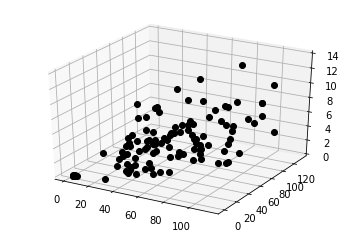

In [108]:
fig = plt.figure()
ax1 = fig.add_subplot(111, projection="3d")
ax1.plot(V[0], V[1], V[2], "ko")


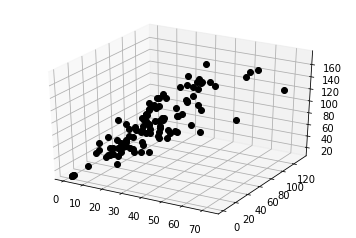

In [107]:
fig = plt.figure()
ax1 = fig.add_subplot(111, projection="3d")
ax1.plot(mbbVolume[0], mbbVolume[1], mbbVolume[2], "ko")


In [112]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression().fit(mbbVolume[0].reshape(-1,1), mbbVolume[1].reshape(-1,1))
print(regr.score(mbbVolume[0].reshape(-1,1), mbbVolume[1].reshape(-1,1)))

0.51763216708933


In [113]:
regr = LinearRegression().fit(mbbVolume[0].reshape(-1,1), mbbVolume[2].reshape(-1,1))
print(regr.score(mbbVolume[0].reshape(-1,1), mbbVolume[2].reshape(-1,1)))

0.5660858728917219


In [114]:
regr = LinearRegression().fit(mbbVolume[1].reshape(-1,1), mbbVolume[2].reshape(-1,1))
print(regr.score(mbbVolume[1].reshape(-1,1), mbbVolume[2].reshape(-1,1)))

0.7284558413742576


In [32]:
lb = label(input=cleftsA, background=0, connectivity=2, return_num=True)
volume = []
mbbVolume = []
points = getConnectedPoints(1)
v = getVolume(points)
volume.append([v[1]-v[0],v[3]-v[2],v[5]-v[4]])


In [33]:
np.array(points).shape

(1330, 3)

In [34]:
l3D

[[[230, 1081, 0]],
 [[230, 1081, 1]],
 [[230, 1081, 2]],
 [[230, 1081, 3]],
 [[230, 1081, 4]],
 [[230, 1081, 5]],
 [[230, 1081, 6]],
 [[230, 1081, 7]],
 [[230, 1081, 8]],
 [[230, 1081, 9]],
 [[230, 1082, 0]],
 [[230, 1082, 1]],
 [[230, 1082, 2]],
 [[230, 1082, 3]],
 [[230, 1082, 4]],
 [[230, 1082, 5]],
 [[230, 1082, 6]],
 [[230, 1082, 7]],
 [[230, 1082, 8]],
 [[230, 1082, 9]],
 [[230, 1083, 0]],
 [[230, 1083, 1]],
 [[230, 1083, 2]],
 [[230, 1083, 3]],
 [[230, 1083, 4]],
 [[230, 1083, 5]],
 [[230, 1083, 6]],
 [[230, 1083, 7]],
 [[230, 1083, 8]],
 [[230, 1083, 9]],
 [[230, 1084, 0]],
 [[230, 1084, 1]],
 [[230, 1084, 2]],
 [[230, 1084, 3]],
 [[230, 1084, 4]],
 [[230, 1084, 5]],
 [[230, 1084, 6]],
 [[230, 1084, 7]],
 [[230, 1084, 8]],
 [[230, 1084, 9]],
 [[230, 1085, 0]],
 [[230, 1085, 1]],
 [[230, 1085, 2]],
 [[230, 1085, 3]],
 [[230, 1085, 4]],
 [[230, 1085, 5]],
 [[230, 1085, 6]],
 [[230, 1085, 7]],
 [[230, 1085, 8]],
 [[230, 1085, 9]],
 [[230, 1086, 0]],
 [[230, 1086, 1]],
 [[230, 1086

In [35]:
l3D = get3DPoints(points)
pts = np.array(l3D)
pts.shape

(13300, 3)

In [23]:
len(l3D)

10

In [ ]:
edges = EdgesOfHull(pts)
mbb = findOBBEdge(edges,pts)
mv = getMBBVolume(mbb)
mbbVolume.append(mv)